In [7]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cross_validation  import *
from polyfit import *




ImportError: attempted relative import with no known parent package

## Polynomial Fit for first 20 points

The data has gaussian noise with 0 mean i.e $N(h(x)|t,\frac{1}{\beta})$ , where $\frac{1}{\beta}$ is variance of the noise distribution

$\textbf{Load and plotting data}$

In [175]:
data = np.genfromtxt('./gaussian.csv',delimiter=',')
X, Y = data[:20, 0], data[:20, 1]
X, Y = zip(*sorted(zip(X, Y)))
X,Y=np.array(X),np.array(Y)
print(X.shape)


(20,)


## Error Minimization on given number of points


### (a) Optimization using **Batch Gradient descent** on given data

Notice that convergence of gradient descent algorithm is quite slow , took around 50,000 iterations on an average to converge.

In [ ]:
degrees = np.arange(0,20)
models,w_ini =[],np.zeros(1).T
for degree in degrees:
    model = polyfit(degree=degree,max_iter=50000,steps=1e-3)
    model.fit(X,Y,w_ini=w_ini)
    w_ini=np.append(model.w,[[0]],axis=0)
    models.append(model)


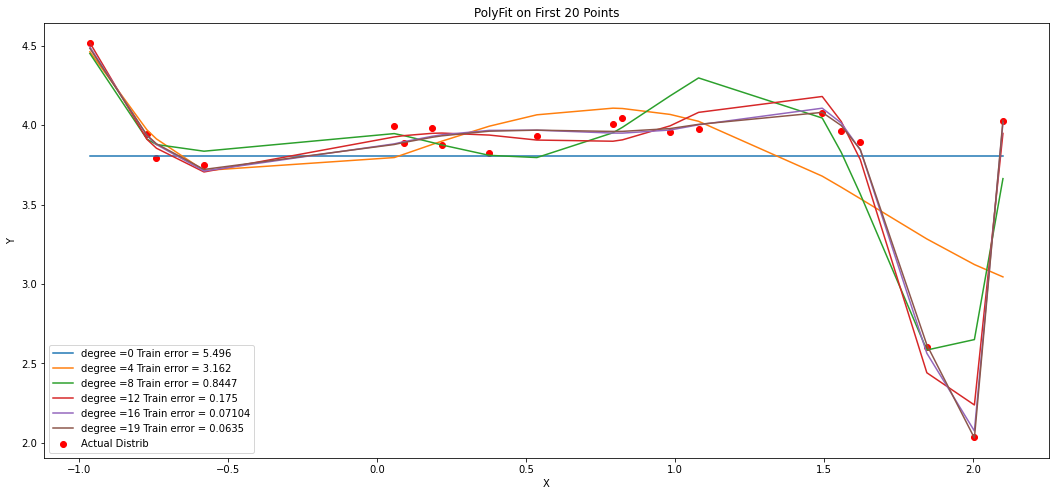

In [10]:
#After training lets plot all the curves

plt.figure(figsize=(18,8))
#Plotting curves
plt.scatter(X,Y,label='Actual Distrib',color='red')
for i in  (0,4,8,12,16,19):
    plt.plot(np.sort(X),models[i].pred(np.sort(X)),label='degree ='+str (models[i].degree)+(" Train error = ")+str(np.float16(models[i].train_error)))
plt.legend(),plt.title('PolyFit on First 20 Points'),plt.xlabel('X'),plt.ylabel('Y')
plt.show()

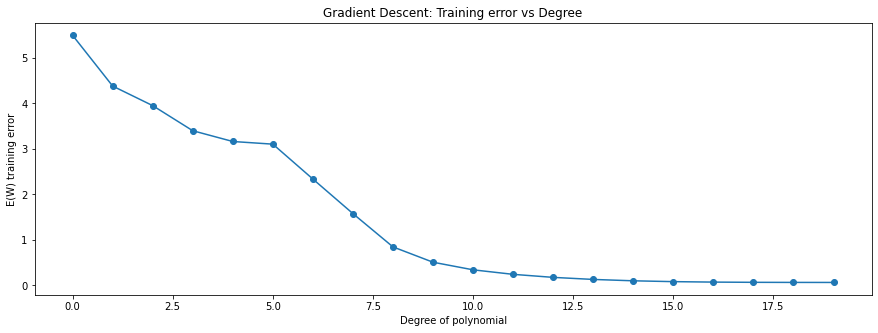

In [11]:
grad_error = [model.train_error for model in models]
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,len(grad_error)),grad_error,'-o')
plt.title("Gradient Descent: Training error vs Degree"),plt.xlabel("Degree of polynomial"),plt.ylabel("E(W) training error")
plt.show()

#### Observations:
1. **Starting degree 8 onwards** the training error is reduced drastically , hence  $degree\geq 8 $ are good fit to our data set
2. Training error reduces as the degree of poynomial is increased ,but this occurs at the expense of the increase complexity of model.

### **Variation of error vs iteration  of gradient descent** 

From below we can say the gradient descent algorithm converges very fast for the first 5000 iteration , after that the convergence of gradient descent is very slow in successive iteration.
Here 1 iteration corresponds to 1 pass over the data set , hence in our case 1 iteration implies 1 pass over all 20 points.

Error is monotonically decresing as number of iterations increases


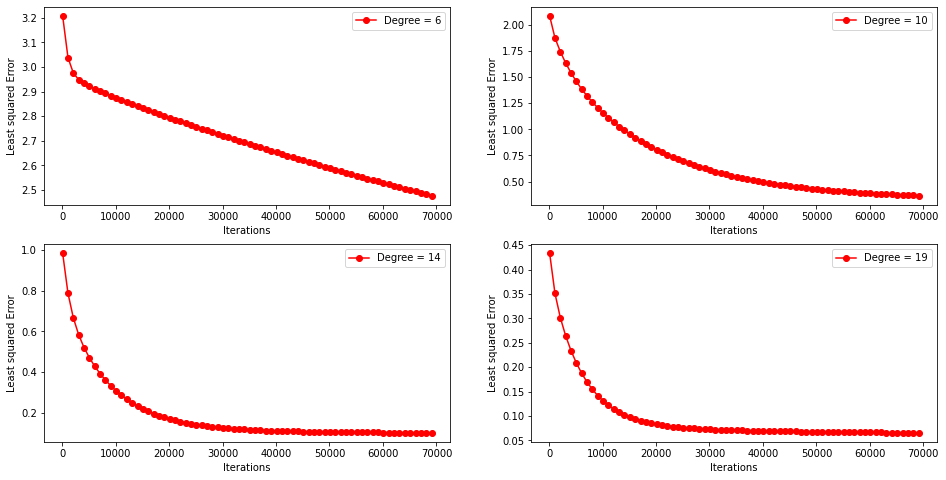

In [168]:
start,gaps,max_iter=100,1000,70000
fig,axes =plt.subplots(nrows=2,ncols=2,figsize=(16,8))
axes=np.array(axes)

for degree ,ax in zip([6,10,14,19],axes.reshape(-1)):
    iters = np.arange(start,max_iter,gaps)
    modeli = polyfit(degree=degree,max_iter=max_iter,steps=5e-4)
    modeli.fit(X,Y,error_gaps=gaps)
    iter_errors = modeli.train_error_gapped[1:]
    ax.plot(iters,iter_errors,'-o',color='red')
    ax.set_xlabel('Iterations'),ax.set_ylabel('Least squared Error'),ax.legend(['Degree = '+str(degree)])


### Variation of Error $E(W)$ vs batch size in gradient descent

<span class="mark">Since the data set is quite small i.e only 20 points</span> . Also the data was normalized before the grad desccent thus the <span class="mark">batch gradient descent performed similar</span> on all batches

In [ ]:
error_batches=[]
max_iter=1000
for batch_size in np.arange(1,20,2):
    model_b= polyfit(degree=5,batch_size=batch_size,max_iter=max_iter,method='grad')
    model_b.fit(X,Y,error_gaps=10)
    error_batches.append(model_b.train_error_gapped)


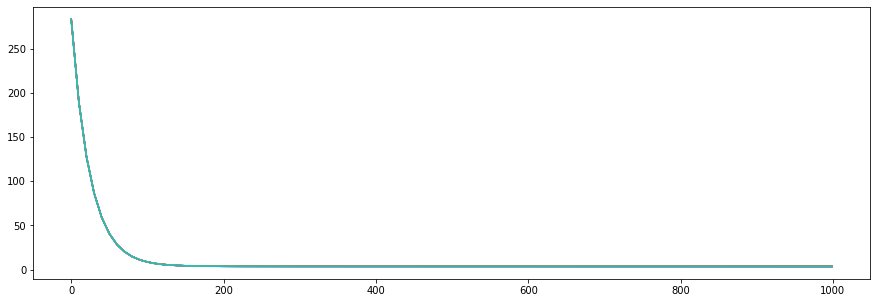

In [268]:
plt.figure(figsize=(15,5))
for eb in error_batches:
    x=[coord[0] for coord in eb]
    y=[coord[1] for coord in eb]
    plt.plot(x,y)
#     plt.ylim(0,10)
#     plt.xlim(0,100)

### (b) Optimization using **PIV** (penrose inverse matrix)

Below is polynomial fitting plot of various degree of polynomials optimized using PIV method . 

**Observations:**
Starting $degree \geq 15$ the PIV fails , thus gives poor fitting , as shown below.This is the reason we cannot rely on PIV method for fitting higher degree poynomials on our data set.

In [211]:
degrees = np.arange(0,21)
piv_models=[]
for degree in degrees:
    model = polyfit(degree=degree,method='piv')
    model.fit(X,Y)
    piv_models.append(model)

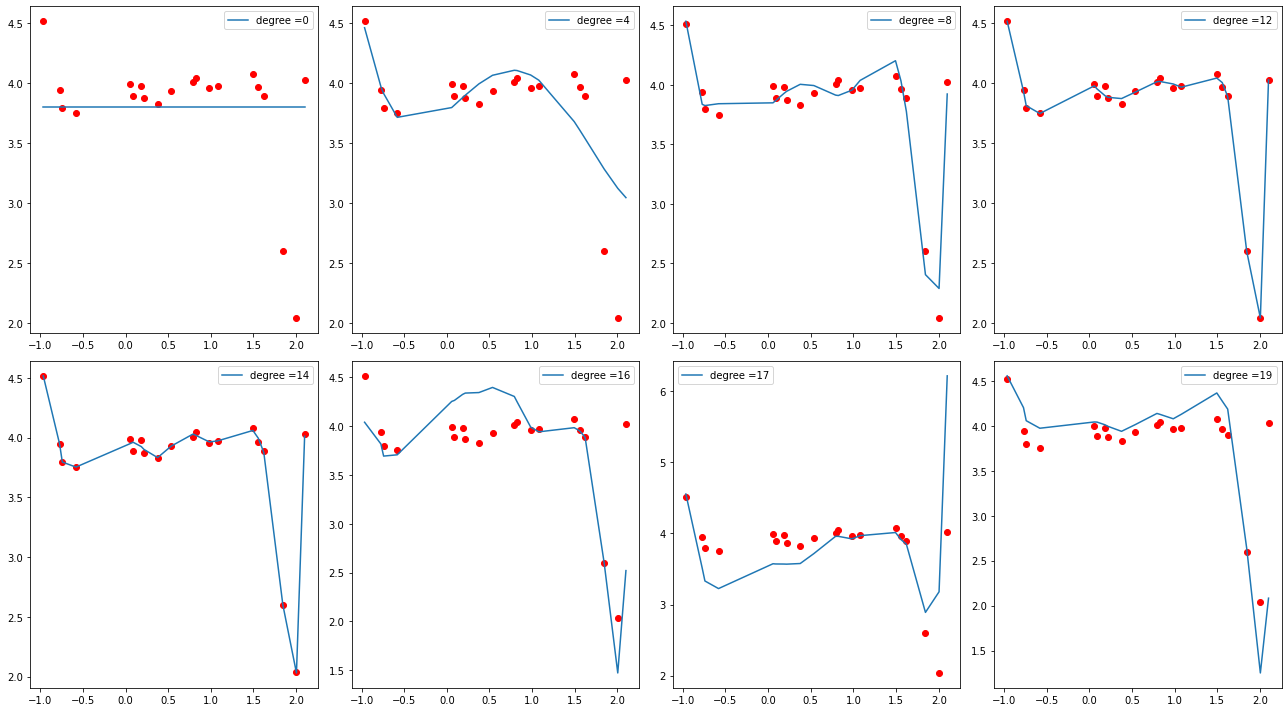

In [6]:
#After training lets plot all the curves
fig,axes =plt.subplots(nrows=2,ncols=4,figsize=(18,10))
axes=np.array(axes)

#Plotting curves

for i,ax in  zip ([0,4,8,12,14,16,17,19],np.reshape(axes,-1)):
    ax.scatter(X,Y,label='Actual Distrib',color='red')
    ax.plot(np.sort(X),piv_models[i].pred(np.sort(X)),label='degree ='+str (piv_models[i].degree))
    ax.legend(['degree ='+str(piv_models[i].degree)])
plt.tight_layout()
plt.show()

In [216]:
print(np.ravel(piv_models[9].w))

[ 3.99399065 -0.56158887 -0.16833793  4.93082264 -2.41734063 -8.69985778
  6.99587172  3.09004417 -4.22105658  1.00545962]


### Error vs degree of poynomial 

Since PIV fails for degree>=5 hence the error shoots up

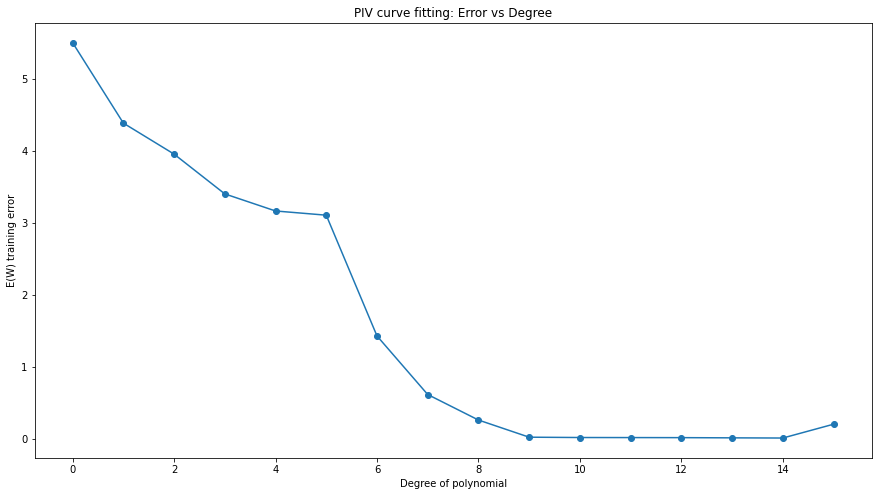

In [7]:
piv_error = [piv_model.train_error for piv_model in piv_models[:16]]
plt.figure(figsize=(15,8))
plt.plot(np.arange(0,len(piv_error)),(piv_error),'-o')

plt.title("PIV curve fitting: Error vs Degree"),plt.xlabel("Degree of polynomial"),plt.ylabel("E(W) training error")
plt.show()

## Good fit of polynomial (Underfitting , overfitting) (without regularization)

We know the  $\textbf{train error} -> 0$ as the degree of poynomial M increases but this lead to overfitting of the model over the underlying data set.

**Test validation** 
To test a model we will partition our data i.e 20 points into test and train data . The model is trained on trained data and scored on the test data. 

Several models are scored using above schema , one with the best score i.e in our case the least error is chosen.

**I have used K-fold cross validation method to score the models with variable hyper-paramters**.

The k-fold cross validation method is implemented in file cross-validation.py

In [8]:

test_err, train_err = [], []
posssible_degree = np.arange(0, 14, 1)
for degree in posssible_degree:
    mse_train, mse_test = kfold_cross_validation(
        X, Y, degree=degree, method='piv', K=10)
    test_err.append(mse_test), train_err.append(mse_train)




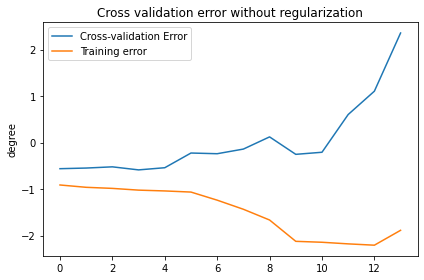

In [9]:
fig,axes = plt.subplots()
plt.plot(posssible_degree,np.log10(test_err),label='Cross-validation Error')
plt.plot(posssible_degree,np.log10(train_err),label='Training error')
plt.ylabel("$\log_{10}{E_{RMS}}$"),plt.ylabel("degree")
plt.legend()
plt.title("Cross validation error without regularization")
plt.tight_layout()    



#### Observations:
1. The points 20 are too low in number thus we *donot* get the an expected $U$ shaped curved depicting decrese in $(bias)^2$ and increase in $variance$ ,giving an sweet-spot in between.
2. The error is contributed from following
    1. test variance (= variance due to test sample size) : Since the test points are too low in our model thus the test error itsef have a high variance.
    2. **Model instability** variance due to training sample size
    3. **testing bias** 

Thus we see at lower degree of polynomial the cross validation is dominated by bias in model ,but due to so low count of data points the bias does-not dominate that well over the data , hence the varince starts dominating soon.

At $degree =9$ there is sudden dip in the bias , hence we get a see spot where the total bias and variance sum is minimized. 
For $degree\geq 10$ , the varince shoot up

### Hence polynomial of $degree =9$ fits our data well (low train and test error)

### region ($degree<9$ high training error -> Underfitting)
### region ($degree \geq 10 $ high testing error -> overfitting)

## Estimate the noise variance

# Introduce the regularization (lmda) (Bayesian)(posterior)

Introducing paramters $\lambda$ to prevent overfitting case , i.e prevent our $w$ to take abrupt values 
$$E(w,\lambda)_trainingError = \sum{(h(x_i)-t_i)^2} + \lambda (||w||)^2$$

We intriduce a regularized error to our model

# Noise variance estimation

In [36]:
X,Y=X[:20],Y[:20]
model=polyfit(degree=11,method='piv')

model.fit(X,Y)
score=model.score(X,Y)
variance=1/score
variance

49.99395169394645

In [60]:
beta=[]
for degree in np.arange(1,14,1):
    model=polyfit(degree=degree,method='piv')
    model.fit(X,Y)
    beta.append(X.shape[0]/model.train_error)

Text(0.5, 0, 'degree of poynomial')

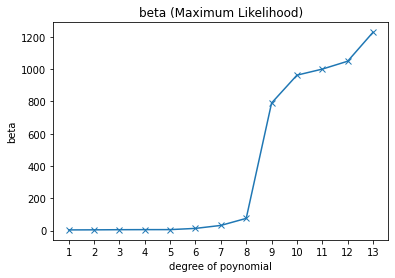

In [61]:
plt.plot(np.arange(1,14,1),beta,'-x')
plt.title('beta (Maximum Likelihood)')
plt.ylabel("beta"),plt.xticks(np.arange(1,14,1))
plt.xlabel('degree of poynomial')

In [55]:
X,Y=X[:20],Y[:20]
model=polyfit(method='piv',degree=9)
model.fit(X,Y)
hx=np.ravel(model.pred(X))
noise=hx-np.ravel(Y)


In [56]:
import seaborn as sbn


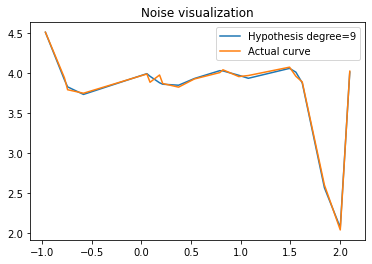

In [59]:
plt.plot(X,hx)
plt.plot(X,Y)
plt.title("Noise visualization")
plt.legend(['Hypothesis degree=9','Actual curve'])


-6.66799948589869e-14


<AxesSubplot:ylabel='Count'>

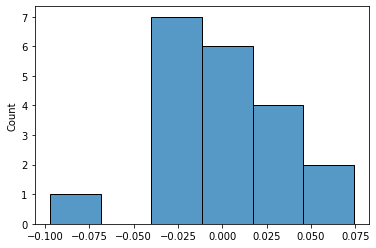

In [63]:
print(np.mean(noise))
sbn.histplot(noise)

In [65]:
variance =1/beta[8]
np.sqrt(variance)


0.03558116337342919

Guaussain distribution with mean=0 and variance = 1/beta(poly=9) should look similar to our distribution

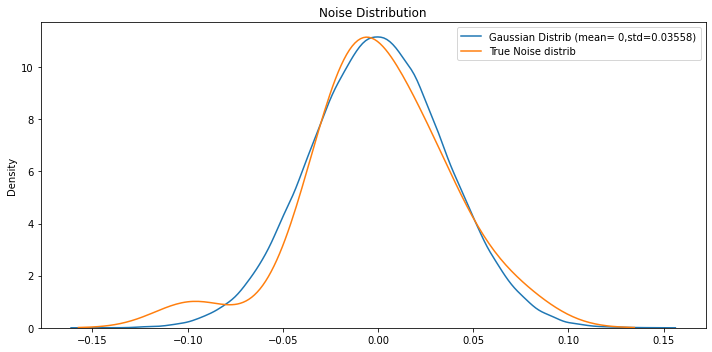

In [70]:
fig, ax = plt.subplots(figsize=(10, 5))

distrib = (np.random.normal(0,np.sqrt(variance),size=100000))
sbn.kdeplot(distrib, ax=ax, label="Gaussian Distrib (mean= 0,std=0.03558)")
sbn.kdeplot(noise, ax=ax, label="True Noise distrib")
ax.legend()
ax.set_title("Noise Distribution")
plt.tight_layout()


$gaussianNoise = N(0,(0.03558)^{2})$

# Hyper Parameter Tuning (regularization approach)

In [220]:

df= pd.DataFrame(columns=['log10(lmda)','degree','test_err','train_err'])
df.head()

,log10(lmda),degree,test_err,train_err


In [221]:
df = pd.DataFrame(columns=['lmda', 'degree', 'test_err', 'train_err'])
df.head()
posssible_degree =np.arange(7,15,1)
lmda= [10**i for i in np.arange(1.0,-5.0,-0.2)]
for lm in lmda:
    for degree in posssible_degree:
        train_err,test_err=kfold_cross_validation(X,Y,degree=degree,K=10,lmda=lm,method='piv')
        df.loc[-1]={'lmda':np.log10(lm),'degree':degree,'test_err':test_err,'train_err':train_err}
        df.index = df.index + 1
        df = df.sort_index()



In [222]:
df.sort_values('test_err')


,lmda,degree,test_err,train_err
27,-4.2,11,0.069570,0.009619
34,-4.0,12,0.078175,0.009920
26,-4.2,12,0.082040,0.009425
19,-4.4,11,0.087020,0.008962
0,-4.8,14,0.097890,0.007837
...,...,...,...,...
38,-4.0,8,0.370015,0.016381
30,-4.2,8,0.382758,0.016179
22,-4.4,8,0.386185,0.016015
14,-4.6,8,0.391108,0.015874


In [224]:
# NOISE ESTIMATION
model = polyfit(method='piv', degree=14,lmda=10**(-4.6))
model.fit(X, Y)
hx = np.ravel(model.pred(X))
noise = hx-np.ravel(Y)
std = np.sqrt(model.score(X,Y)/X.shape[0])
print(np.ravel(model.w))

[ 4.00508911e+00 -2.32331032e-02 -7.08705280e-01  1.34058586e+00
  1.09848573e+00 -3.16688496e+00  4.49931451e-01  1.58108297e+00
 -5.82997950e-01  6.70898630e-02 -1.18962016e-01  1.58515472e-02
  2.62794355e-03  7.11685818e-03 -1.34651068e-03]


0.04607624198786896


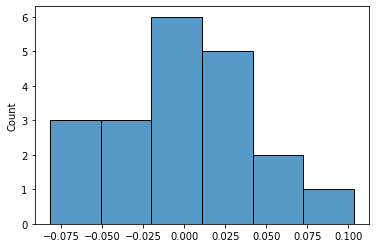

In [157]:
sbn.histplot(noise)
print(std)

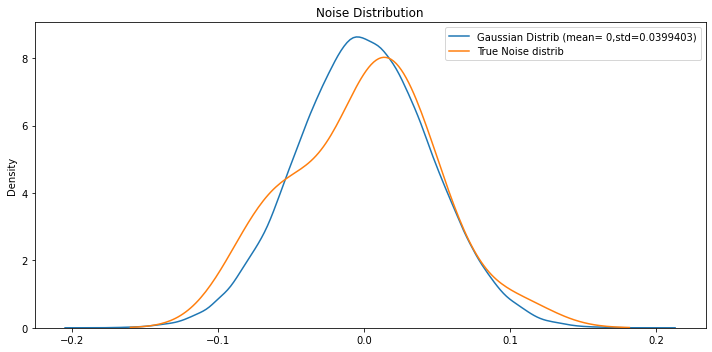

In [158]:
fig, ax = plt.subplots(figsize=(10, 5))

distrib = (np.random.normal(0, std, size=100000))
sbn.kdeplot(distrib, ax=ax,
            label="Gaussian Distrib (mean= 0,std=0.0399403)")
sbn.kdeplot(noise, ax=ax, label="True Noise distrib")
ax.legend()
ax.set_title("Noise Distribution")
plt.tight_layout()


# Repeat for 100 points dataset

In [178]:
X, Y = data[:, 0], data[:, 1]
X, Y = zip(*sorted(zip(X, Y)))
X, Y = np.array(X), np.array(Y)
print(X.shape)


(100,)


## Error Minimization on given number of points


### (a) Optimization using **Batch Gradient descent** on given data

Notice that convergence of gradient descent algorithm is quite slow , took around 50,000 iterations on an average to converge.

In [183]:
degrees = np.arange(5,15)
models=[]
for degree in degrees:
    model = polyfit(degree=degree,max_iter=20000,steps=5e-4)
    model.fit(X,Y)
    models.append(model)
    print(degree,"done")


5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done


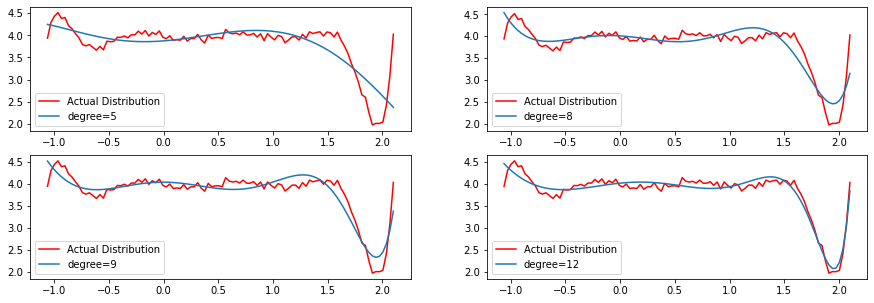

In [196]:
#After training lets plot all the curves
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(15,5))
axes=np.array(axes)
#Plotting curves
for i ,ax in  zip((5,8,9,12),np.reshape(axes,-1)):
    ax.plot(X, Y, label='Actual Distrib', color='red')
    ax.plot((X),models[i-5].pred(X))
    ax.legend(['Actual Distribution','degree='+str(i)]),
plt.show()


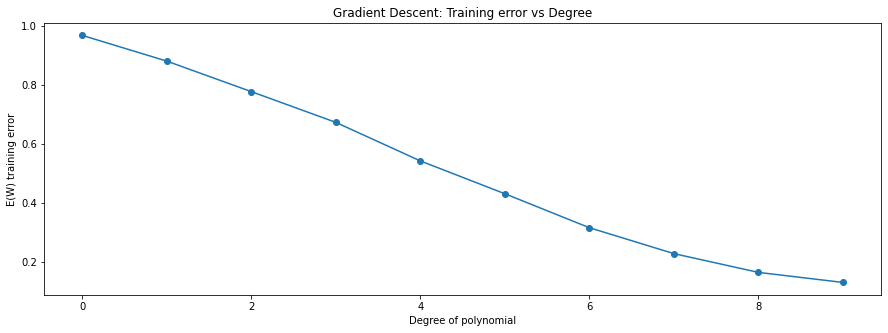

In [197]:
grad_error = [model.train_error for model in models]
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,len(grad_error)),np.log10(grad_error),'-o')
plt.title("Gradient Descent: Training error vs Degree"),plt.xlabel("Degree of polynomial"),plt.ylabel("E(W) training error")
plt.show()

#### Observations:
1. **Starting degree 8 onwards** the training error is reduced drastically , hence  $degree\geq 8 $ are good fit to our data set
2. Training error reduces as the degree of poynomial is increased ,but this occurs at the expense of the increase complexity of model.

### **Variation of error vs iteration  of gradient descent** 

From below we can say the gradient descent algorithm converges very fast for the first 5000 iteration , after that the convergence of gradient descent is very slow in successive iteration.
Here 1 iteration corresponds to 1 pass over the data set , hence in our case 1 iteration implies 1 pass over all 20 points.

Error is monotonically decresing as number of iterations increases


8 Done
9 Done
10 Done
11 Done


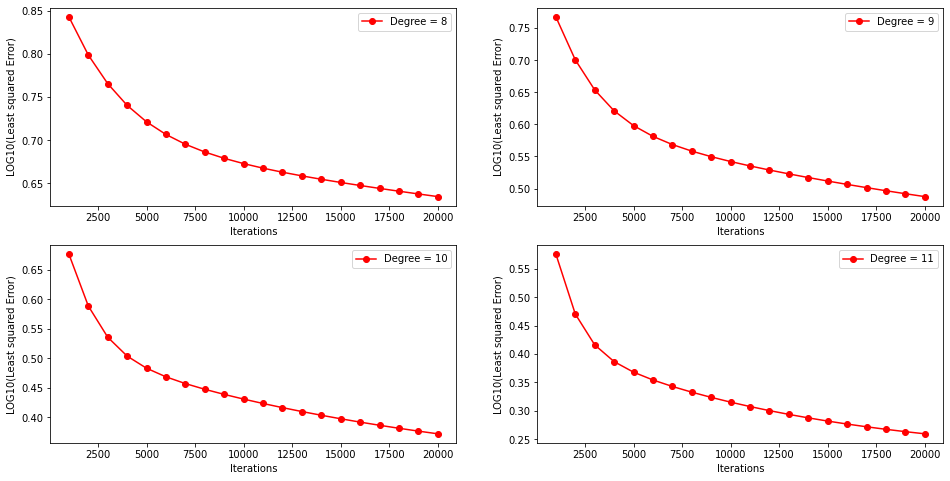

In [209]:
start,gaps,max_iter=100,1000,20000
fig,axes =plt.subplots(nrows=2,ncols=2,figsize=(16,8))
axes=np.array(axes)

for degree ,ax in zip([8,9,10,11],axes.reshape(-1)):
    iters = np.arange(start,max_iter,gaps)
    modeli = polyfit(degree=degree,max_iter=max_iter,steps=1e-3)
    modeli.fit(X,Y,error_gaps=gaps)
    iters = [it[0] for it in modeli.train_error_gapped[1:]]
    iter_errors = [it[1] for it in modeli.train_error_gapped[1:]]
    # print(iter_errors)
    ax.plot(iters,np.log10(iter_errors),'-o',color='red')
    ax.set_xlabel('Iterations'),ax.set_ylabel('LOG10(Least squared Error)'),ax.legend(['Degree = '+str(degree)])
    print(degree,"Done")


### Variation of Error $E(W)$ vs batch size in gradient descent

<span class="mark">Since the data set is quite small i.e only 20 points</span> . Also the data was normalized before the grad desccent thus the <span class="mark">batch gradient descent performed similar</span> on all batches

In [263]:
error_batches=[]
max_iter=1000
for batch_size in np.arange(1,20,2):
    model_b= polyfit(degree=5,batch_size=batch_size,max_iter=max_iter,method='grad')
    model_b.fit(X,Y,error_gaps=10)
    error_batches.append(model_b.train_error_gapped)


In [ ]:
plt.figure(figsize=(15,5))
for eb in error_batches:
    x=[coord[0] for coord in eb]
    y=[coord[1] for coord in eb]
    plt.plot(x,y)
#     plt.ylim(0,10)
#     plt.xlim(0,100)

### (b) Optimization using **PIV** (penrose inverse matrix)

Below is polynomial fitting plot of various degree of polynomials optimized using PIV method . 

**Observations:**
Starting $degree \geq 15$ the PIV fails , thus gives poor fitting , as shown below.This is the reason we cannot rely on PIV method for fitting higher degree poynomials on our data set.

In [72]:
degrees = np.arange(0,20)
piv_models=[]
for degree in degrees:
    model = polyfit(degree=degree,method='piv')
    model.fit(X,Y)
    piv_models.append(model)

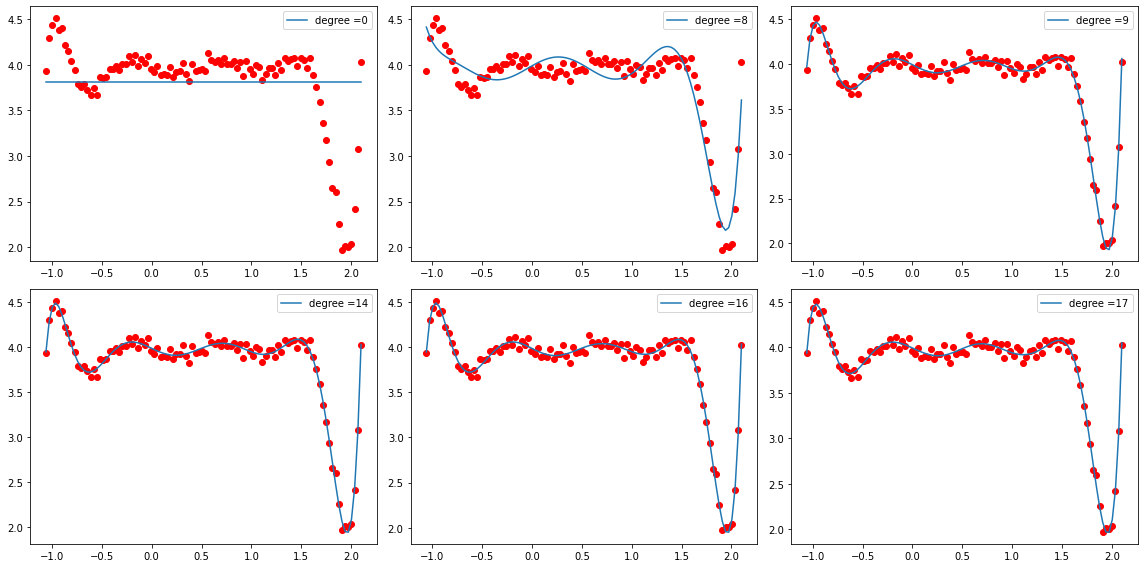

In [73]:
#After training lets plot all the curves
fig,axes =plt.subplots(nrows=2,ncols=3,figsize=(16,8))
axes=np.array(axes)

#Plotting curves

for i,ax in  zip ([0,8,9,14,16,17],np.reshape(axes,-1)):
    ax.scatter(X,Y,label='Actual Distrib',color='red')
    ax.plot(np.sort(X),piv_models[i].pred(np.sort(X)),label='degree ='+str (piv_models[i].degree))
    ax.legend(['degree ='+str(piv_models[i].degree)])
plt.tight_layout()
plt.show()


### Error vs degree of poynomial 

Since PIV fails for degree>=17 hence the error shoots up as PIV method fails.

Degree=9 polynomial fits our curve nicely.

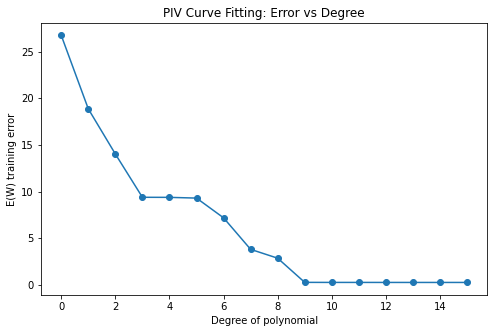

In [74]:
piv_error = [piv_model.train_error for piv_model in piv_models[:16]]
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,len(piv_error)),piv_error,'-o')

plt.title("PIV Curve Fitting: Error vs Degree"),plt.xlabel("Degree of polynomial"),plt.ylabel("E(W) training error")
plt.show()

## Good fit of polynomial (Underfitting , overfitting)(Maximum Likelihood) (without regularization)

In [75]:
test_err, train_err = [], []
posssible_degree = np.arange(0, 18, 1)
for degree in posssible_degree:
    mse_train, mse_test = kfold_cross_validation(
        X, Y, degree=degree, method='piv', K=10)
    test_err.append(mse_test), train_err.append(mse_train)




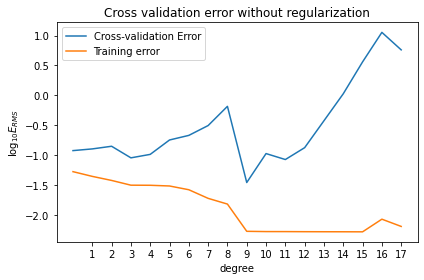

In [76]:
ig, axes = plt.subplots()
plt.plot(posssible_degree, np.log10(test_err), label='Cross-validation Error')
plt.plot(posssible_degree, np.log10(train_err), label='Training error')
plt.ylabel("$\log_{10}{E_{RMS}}$"), plt.xlabel("degree")
plt.xticks(np.arange(1,18,1))
plt.legend()
plt.title("Cross validation error without regularization")
plt.tight_layout()


## Estimate the noise variance

In [169]:
model=polyfit(degree=9,method='piv')
model.fit(X,Y)
hx=np.ravel(model.pred(X))
noise= hx-np.ravel(Y)
std= np.sqrt(model.score(X,Y)/X.shape[0])
std

0.05114789581525336

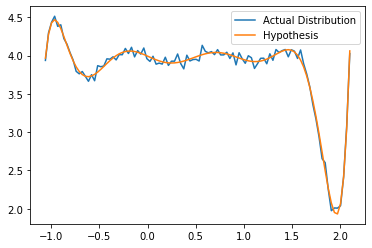

In [170]:
plt.plot(X,Y,label="Actual Distribution")
plt.plot(X,hx,label="Hypothesis")
plt.legend()

In [ ]:
sbn.histplot(noise)

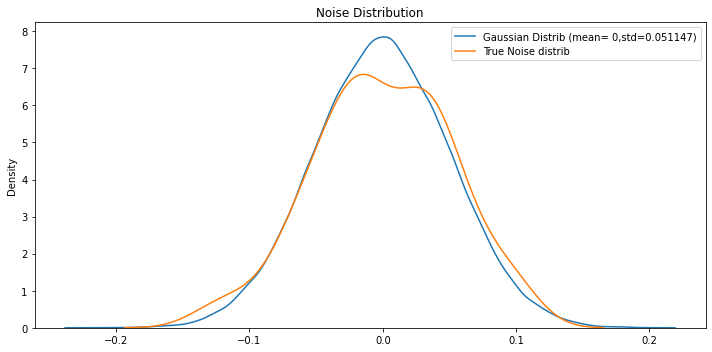

In [171]:
fig, ax = plt.subplots(figsize=(10, 5))

distrib = (np.random.normal(0, std, size=100000))
sbn.kdeplot(distrib, ax=ax,
            label="Gaussian Distrib (mean= 0,std=0.051147)")
sbn.kdeplot(noise, ax=ax, label="True Noise distrib")
ax.legend()
ax.set_title("Noise Distribution")
plt.tight_layout()


# Introduce the regularization (lmda)(bayesian approach)

Introducing paramters $\lambda$ to prevent overfitting case , i.e prevent our $w$ to take abrupt values 
$$E(w,\lambda)_trainingError = \sum{(h(x_i)-t_i)^2} + \lambda (||w||)^2$$

We intriduce a regularized error to our model

# Hyper Parameter Tuning (regularization approach)

In [131]:
X.shape

(100,)

In [160]:
df= pd.DataFrame(columns=['lmda','degree','test_err','train_err'])
df.head()

,lmda,degree,test_err,train_err


In [166]:
df = pd.DataFrame(columns=['lmda', 'degree', 'test_err', 'train_err'])
df.head()
posssible_degree =np.arange(7,15,1)
lmda= [10**i for i in range(-1,-20,-1)]
for lm in lmda:
    for degree in posssible_degree:
        train_err,test_err=kfold_cross_validation(X,Y,degree=degree,K=10,lmda=lm,method='piv')
        df.loc[-1]={'lmda':lm,'degree':degree,'test_err':test_err,'train_err':train_err}
        df.index = df.index + 1
        df = df.sort_index()



In [167]:
df.sort_values('test_err')


,lmda,degree,test_err,train_err
21,1.000000e-17,9,0.035063,0.005369
29,1.000000e-16,9,0.035063,0.005369
37,1.000000e-15,9,0.035063,0.005369
13,1.000000e-18,9,0.035063,0.005369
5,1.000000e-19,9,0.035063,0.005369
...,...,...,...,...
8,1.000000e-18,14,1.065577,0.005275
32,1.000000e-15,14,1.065577,0.005275
24,1.000000e-16,14,1.065577,0.005275
16,1.000000e-17,14,1.065577,0.005275


In [173]:
model = polyfit(degree=9, method='piv',lmda=1e-17)
model.fit(X, Y)
hx = np.ravel(model.pred(X))
noise = hx-np.ravel(Y)
std = np.sqrt(model.score(X,Y)/X.shape[0])
std
print(np.ravel(model.w))


[ 3.99399065 -0.56158887 -0.16833793  4.93082264 -2.41734063 -8.69985778
  6.99587172  3.09004417 -4.22105658  1.00545962]


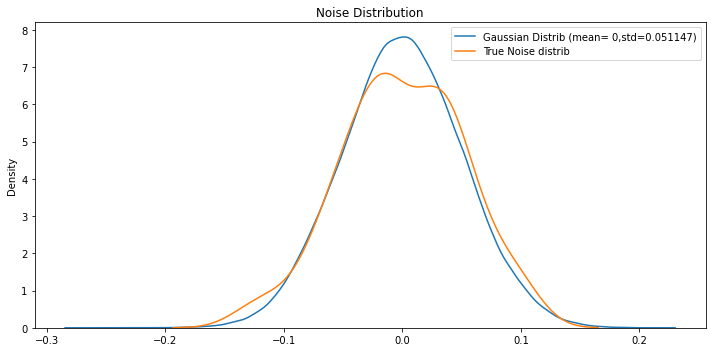

In [164]:
fig, ax = plt.subplots(figsize=(10, 5))

distrib = (np.random.normal(0, std, size=100000))
sbn.kdeplot(distrib, ax=ax,
            label="Gaussian Distrib (mean= 0,std=0.051147)")
sbn.kdeplot(noise, ax=ax, label="True Noise distrib")
ax.legend()
ax.set_title("Noise Distribution")
plt.tight_layout()
